In [1]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math
import pprint

from string import ascii_lowercase
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Retrieve the specific functions from ind and proteins.py
indels_path="/home/maya/InDelScanner"  # /PATH/TO/InDelScanner
if indels_path not in sys.path:
    sys.path.append(indels_path)

from ipynb.fs.defs.F01_Library_diversity import convert_variant_to_dict, single_fraction_enrichment, passes_restriction

os.chdir("/mnt/c/Users/Maya/Documents/03_Kinases/code_check")

In [3]:
with open('mek.pickle', 'rb') as pf:
    mek = pickle.load(pf)

df_pos = pd.read_csv('df_pos.csv', index_col=0)
    
pos = df_pos.to_dict()

In [4]:
# Set general restrictions stemming from SpliMLib library design
aa_2 = ['A', 'Δ']
aa_12 = ['A','G','P','Y','D','K','M','V','I','L','F','W']
aa_13 = aa_12 +  ['Δ']
splimlib = {'6': aa_12, '9': aa_12, '11': aa_12, '13': aa_12, '7a': aa_13, '8a': aa_2}

Here, the filtering steps have been completed: the result is a dataset with 29.5K variants that we are confident to call active MEK1 variants. Next, I use these variants to explore the enrichment of different amino acids amongst positive variants.

## 1D enrichment pie charts and heat maps

In [5]:
from ipynb.fs.defs.F01_Library_diversity import make_composition_plot_per_position, single_fraction_enrichment

In [6]:
aa_order = ['A','G','P','Y','D','K','M','V','I','L','F','W','Δ']
valid_pos = ['6', '7a', '8a', '9', '11', '13']

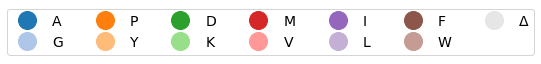

In [7]:
# Set palette and the order of amino acids for meaningful colors
pal = sns.color_palette("tab20")[:13]
pal[12] = (0.9, 0.9, 0.9) # set deletion to gray
sns.set_palette(pal)

fig, ax = plt.subplots(1,1, figsize=(1,1))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in pal]
fig.legend(markers, aa_order, numpoints=1, loc='center left', ncol=7, markerscale=3, fontsize=14)
ax.axis('off')
plt.tight_layout()
#plt.savefig('Pie_legend.svg')
plt.show()

The first plot is special, and is used to set up later plots.

In [8]:
pos_e = single_fraction_enrichment(pos, 'high', 1, proportion=False) # all variants contribute equally

In [9]:

df_enr = pd.DataFrame.from_dict(pos_e).reindex(aa_order) # reindex to get a sensible colour scheme
df_enr

,6,7a,8a,9,11,13
A,1758,1193,13437,1119,989,2106
G,1841,1290,0,793,768,1411
P,2882,3077,0,2156,1113,2116
Y,2001,1364,0,1532,1314,1322
D,937,578,0,946,886,1404
K,2297,1970,0,1514,998,1776
M,2770,1503,0,3188,2288,3097
V,2095,1725,0,1655,2412,3227
I,2175,4946,0,4379,6006,4073
L,4447,6093,0,7077,7460,2995


In [10]:
restrictions  = [[{'7a':['A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y'], '8a':['A']}, '7aX 8aA'],
                 [{'7a':['Δ'], '8a':['Δ']}, '7aΔ 8aΔ'],
                 [{'9':['L'], '11':['L']}, '9L 11L'],
                 [{'9':['I'], '11':['L']}, '9I 11L'],
                 [{'9':['L'], '11':['I']},'9L 11I'],
                 [{'9':['I'], '11':['I']}, '9I 11I'],
                 [{'9':['I', 'L'], '11':['I','L']},'9 I/L\n11 I/L'],
                 [{'9': ['A', 'D', 'F', 'G', 'K', 'M', 'P', 'V', 'W', 'Y'], 
                   '11':['A', 'D', 'F', 'G', 'K', 'M', 'P', 'V', 'W', 'Y']}, '9 no I/L\n11 no I/L']
                 ]

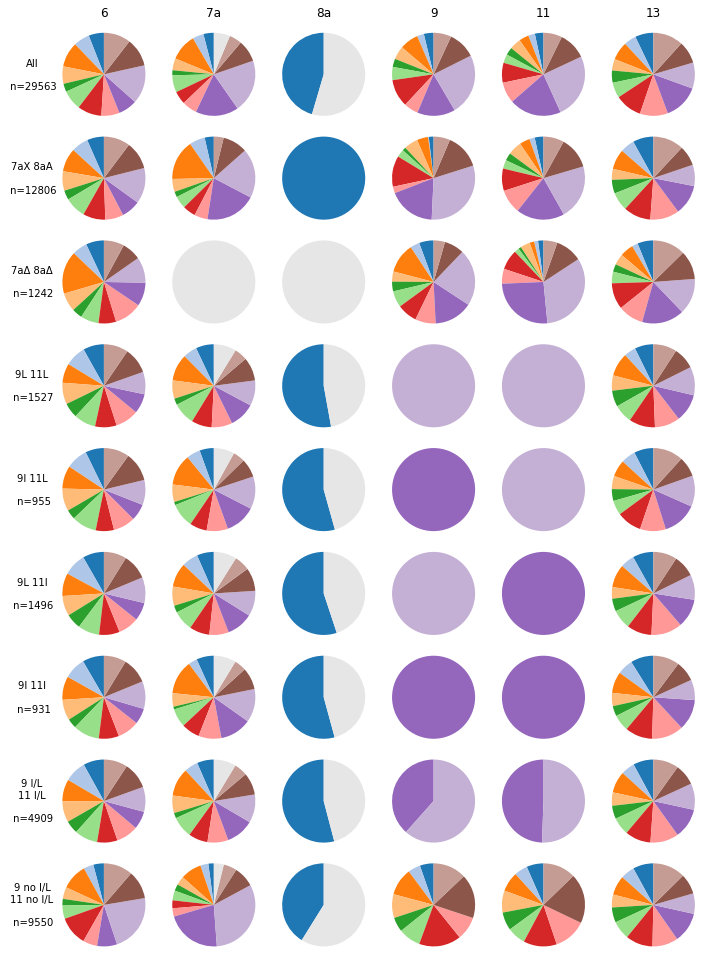

In [11]:
fig, axes = plt.subplots(len(restrictions)+1,6, 
                         figsize=(10,(len(restrictions)+1)*1.5),
                         gridspec_kw={'hspace': 0, 'wspace': 0})

# the first row is special and plots the unfiltered variants
row = 0
for i in range(len(valid_pos)):
    axes[row][i].set_title(valid_pos[i])
    axes[row][i].pie(df_enr[valid_pos[i]], startangle=90)
    if i == 0:
        t = 'All\n\n n=' + str(df_enr.sum()[0])
        axes[row][i].set_ylabel(t, rotation='horizontal', labelpad=20, va='center')

# then we loop over the restrictions
for row in range(1,len(restrictions) +1):
    cnts = single_fraction_enrichment(pos, 'high', 1, restrictions[row-1][0], proportion=False)
    df_restrict = pd.DataFrame.from_dict(cnts).reindex(aa_order)
    for i in range(len(valid_pos)):
        axes[row][i].pie(df_restrict[valid_pos[i]], startangle=90)
        if i == 0:
            t = restrictions[row-1][1] +'\n\n n=' + str(df_restrict.sum()[0])
            axes[row][i].set_ylabel(t, rotation='horizontal', labelpad=20, va='center')

plt.tight_layout()
#plt.savefig('Pie_plots.svg')
plt.show()

In [12]:
df_restrict.sum()

6     9550
7a    9550
8a    9550
9     9550
11    9550
13    9550
dtype: int64

### Generate arrays for 15 cross-position enrichments

In [13]:
from ipynb.fs.defs.F01_Library_diversity import convert_variant_to_dict

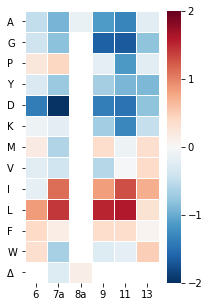

In [14]:
crange=[-2, 2]
fig, axes = plt.subplots(1,1, figsize=(3,5))

# the first row is special and plots the unfiltered variants
ax = axes
log_enr = (df_enr/(df_enr.sum()/df_enr.astype(bool).sum())).apply(np.log2)   
sns.heatmap(log_enr, vmin=crange[0], vmax=crange[1], linewidths=1, ax=ax, cmap="RdBu_r", 
            cbar=True, cbar_kws={'ticks': [crange[0], crange[0]/2, 0, crange[1]/2, crange[1]]})
#ax.set_title('High binding - All curated sequences')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
ax.tick_params(axis='y', which='major', pad=14)

# plt.savefig('1D_heatmap_log2_-2to2.svg')
plt.show()

In [15]:
def two_position_joint_count(input, proportion=True):
    """
    input: a Counter 
    posA, posB: two positions between which to generate a heatmap
    """    
    counts = {
        posA : {
            aaA : {
                posB : {
                    aaB: 0 for aaB in splimlib[posB]}
                for posB in valid_pos}
            for aaA in splimlib[posA]}
        for posA in valid_pos}

    for mutation_string, count in input.items():
         # m_by_pos[position] = AA
        m_by_pos = convert_variant_to_dict(mutation_string)
        # check the mutations is one we're interested in
        observed_aa = set(m_by_pos.values())
        if not observed_aa.issubset(aa_13):
            continue
                
        if proportion:
            c = count
        else:
            c = 1
                
        # here this becomes similar as for single enrichments, except we need to loop twice
        for posA, aaA in m_by_pos.items():
            for posB, aaB in m_by_pos.items():
                counts[posA][aaA][posB][aaB] += c

    return counts

In [16]:
two_position_counts = two_position_joint_count(pos['high'], proportion=False)

In [17]:
joint_count_dfs = {posA : {posB : "" for posB in valid_pos} for posA in valid_pos}

for posA in valid_pos:
    for posB in valid_pos:
        dict_data = {aaA : [two_position_counts[posA][aaA][posB][aaB] for aaB in splimlib[posB]] for aaA in splimlib[posA]}
        joint_count_dfs[posA][posB] = pd.DataFrame.from_dict(dict_data, orient='index', columns=splimlib[posB])

In [18]:
joint_count_dfs['6']['11']

,A,G,P,Y,D,K,M,V,I,L,F,W
A,50,23,40,52,20,46,120,137,414,546,195,115
G,31,20,34,49,39,38,108,125,481,640,186,90
P,89,61,106,146,71,98,266,265,535,632,369,244
Y,43,30,53,65,25,42,153,137,469,632,209,143
D,28,21,22,36,36,25,56,55,229,291,76,62
K,25,30,28,57,29,26,179,185,592,739,264,143
M,131,99,156,141,123,106,206,214,475,630,281,208
V,46,41,52,80,33,49,163,166,476,592,218,179
I,82,67,88,108,70,79,155,189,416,524,236,161
L,229,203,256,282,229,265,363,392,695,766,433,334


The enrichment of variants compared to evenly distributed library: $log(\frac{freq_{xy}}{ideal_{xy}})$. 1D plot: $log(\frac{freq_{x}}{ideal_{x}})$

In [19]:
def get_joint_log_dfs(joint_count_dfs, log_function):

    log_freq_dfs = {}
    joint_freq_dfs = {}

    # make the dataframes
    for posA in valid_pos:
        log_freq_dfs[posA] = {}
        joint_freq_dfs[posA] = {}
        for posB in valid_pos:
            total = joint_count_dfs[posA][posB].sum().sum()
            cells = len(splimlib[posA]) * len(splimlib[posB])
            avg_cnt = total/cells

            joint_freq_dfs[posA][posB] = joint_count_dfs[posA][posB]/total
            log_freq_dfs[posA][posB] = (joint_count_dfs[posA][posB]/avg_cnt).apply(log_function)
            
    return joint_freq_dfs, log_freq_dfs

In [20]:
def labelled_cross_enrichment_plot(ax_lims, log_function=np.log10, fname=None):
    
    
    joint_freq_dfs, log_freq_dfs = get_joint_log_dfs(joint_count_dfs, log_function)

    fig, axes = plt.subplots(5, 5, figsize=(13,14),
                             gridspec_kw={'width_ratios': [2,2.2,0.45,2,2],'height_ratios': [2.2,0.4,2,2,2]})
    # figsize (width, height)
    # top left axes = axes[0,0]
    # top row, middle = axes[0,2]
    
    cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]

    for a in range(len(valid_pos)): # a = row index, running from 0 to 4
        for b in range(len(valid_pos)): # b = column index, running from 0 to 4
            if (b == 5) or (a == 0):
                continue
            elif b >= a:
                axes[a-1][b].axis('off')
                continue
            ax = axes[a-1][b]
            sns.heatmap(log_freq_dfs[valid_pos[a]][valid_pos[b]], vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.1, ax=ax, 
                        cmap="RdBu_r", cbar_ax=axes[0][2], 
                        cbar_kws={'extend': 'both', 'ticks': cbar_ticks}) # all colorbars are plotted to the same axes
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
            ax.tick_params(axis='y', which='major', pad=11)
            # draw a box, hide labels
#             for sp in ax.spines.keys():
#                 ax.spines[sp].set_visible(True)

    # colorbar formatting
    axes[0][2].axis('on')

    # add the 1D plot in top right corner
#     ax = axes[0][1]
#     ax.axis('on')
#     log_enr = (df_enr/(df_enr.sum()/df_enr.astype(bool).sum())).apply(log_function)   
#     sns.heatmap(log_enr, vmin=crange[0], vmax=crange[1], linewidths=0.1, ax=ax, cmap="RdBu_r", cbar=False)
#     ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
#     ax.tick_params(axis='y', which='major', pad=11)

   # if fname:
    #    plt.savefig(fname, transparent=True)
    plt.show()

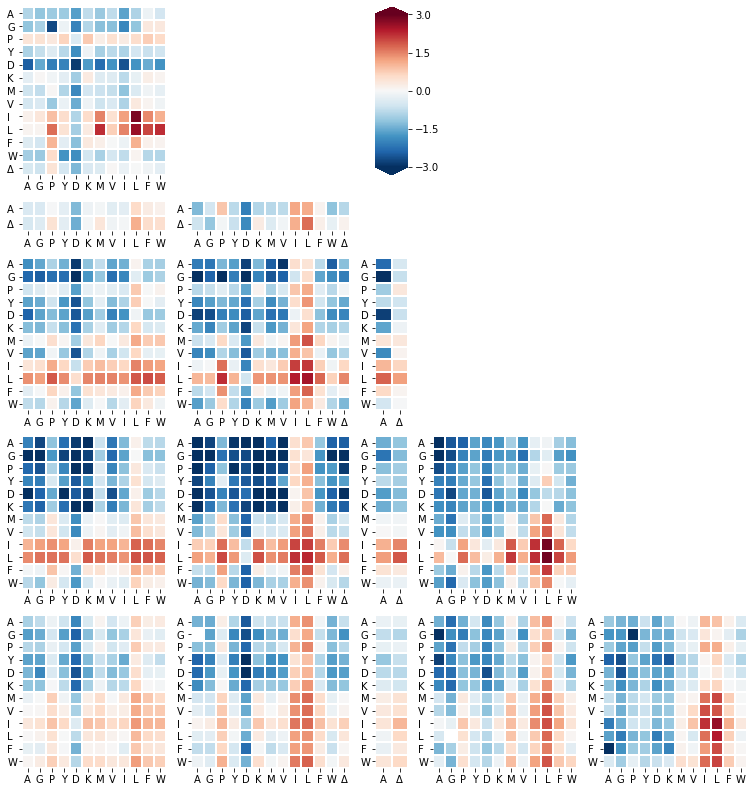

In [21]:
labelled_cross_enrichment_plot((-3,3), np.log2, 'Figure_4_joint_enrichment_labelled.svg')

In [22]:
def cross_enrichment_plot(ax_lims, log_function=np.log10, fname=None):
    
    
    joint_freq_dfs, log_freq_dfs = get_joint_log_dfs(joint_count_dfs, log_function)

    fig, axes = plt.subplots(5, 5, figsize=(13,14),
                             gridspec_kw={'width_ratios': [2,2.2,0.4,2,2],'height_ratios': [2.2,0.4,2,2,2],
                                         'wspace':0.05, 'hspace':0.05})
    # figsize (width, height)
    # top left axes = axes[0,0]
    # top row, middle = axes[0,2]
    
    cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]

    for a in range(len(valid_pos)): # a = row index, running from 0 to 4
        for b in range(len(valid_pos)): # b = column index, running from 0 to 4
            if (b == 5) or (a == 0):
                continue
            elif b >= a:
                axes[a-1][b].axis('off')
                continue
            ax = axes[a-1][b]
            sns.heatmap(log_freq_dfs[valid_pos[a]][valid_pos[b]], vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.1, ax=ax, 
                        cmap="RdBu_r", cbar_ax=axes[0][2], 
                        cbar_kws={'extend': 'both', 'ticks': cbar_ticks}) # all colorbars are plotted to the same axes
            
            # draw a box, hide labels
            for sp in ax.spines.keys():
                ax.spines[sp].set_visible(True)
            # if we don't want any ticks or labels
            ax.tick_params(bottom=False,left=False, labelbottom=False, labelleft=False)

            # turn the labels back on at the outer edges
            if b == 0:
                ax.tick_params(left=True, labelleft=True)
                ax.set_ylabel(valid_pos[a], rotation=0, labelpad=10)
                ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
                ax.tick_params(axis='y', which='major', pad=11)
            if a == 5:
                ax.tick_params(bottom=True, labelbottom=True)
                ax.set_xlabel(valid_pos[b])
            
    # colorbar formatting
    axes[0][2].axis('on')

#     # add the 1D plot in top right corner
#     ax = axes[0][1]
#     ax.axis('on')
#     log_enr = (df_enr/(df_enr.sum()/df_enr.astype(bool).sum())).apply(np.log10)   
#     sns.heatmap(log_enr, vmin=crange[0], vmax=crange[1], linewidths=0.1, ax=ax, cmap="RdBu_r", cbar=False)
#     ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
#     ax.tick_params(axis='y', which='major', pad=11)

    fig.align_labels()

    #plt.tight_layout()
    #if fname:
        #plt.savefig(fname, transparent=True)
    plt.show()

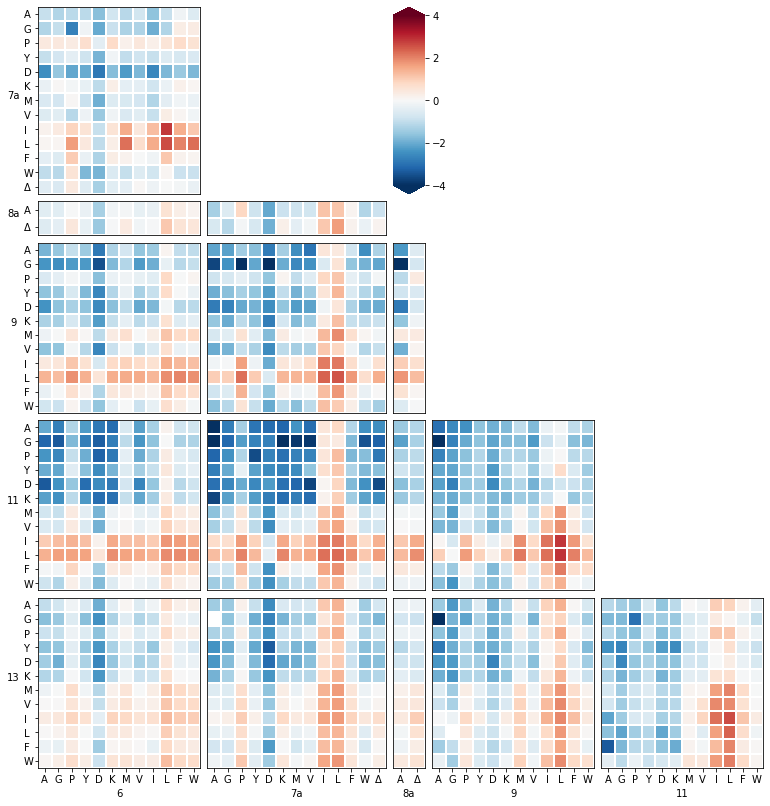

In [23]:
cross_enrichment_plot((-4,4), np.log2, 'Joint_enrichment_log2_-4to4.svg')

#### Conditional probability plots

In [24]:
log_col_dfs = {}

for posA in valid_pos:
    log_col_dfs[posA] = {}
    for posB in valid_pos:
        top_df = joint_count_dfs[posA][posB] # the joint count of a, b co-occurrence
        bottom_df = joint_count_dfs[posA][posB].sum()/joint_count_dfs[posA][posB].astype(bool).sum(axis=0)
        log_col_dfs[posA][posB] = (top_df/bottom_df).apply(np.log2)

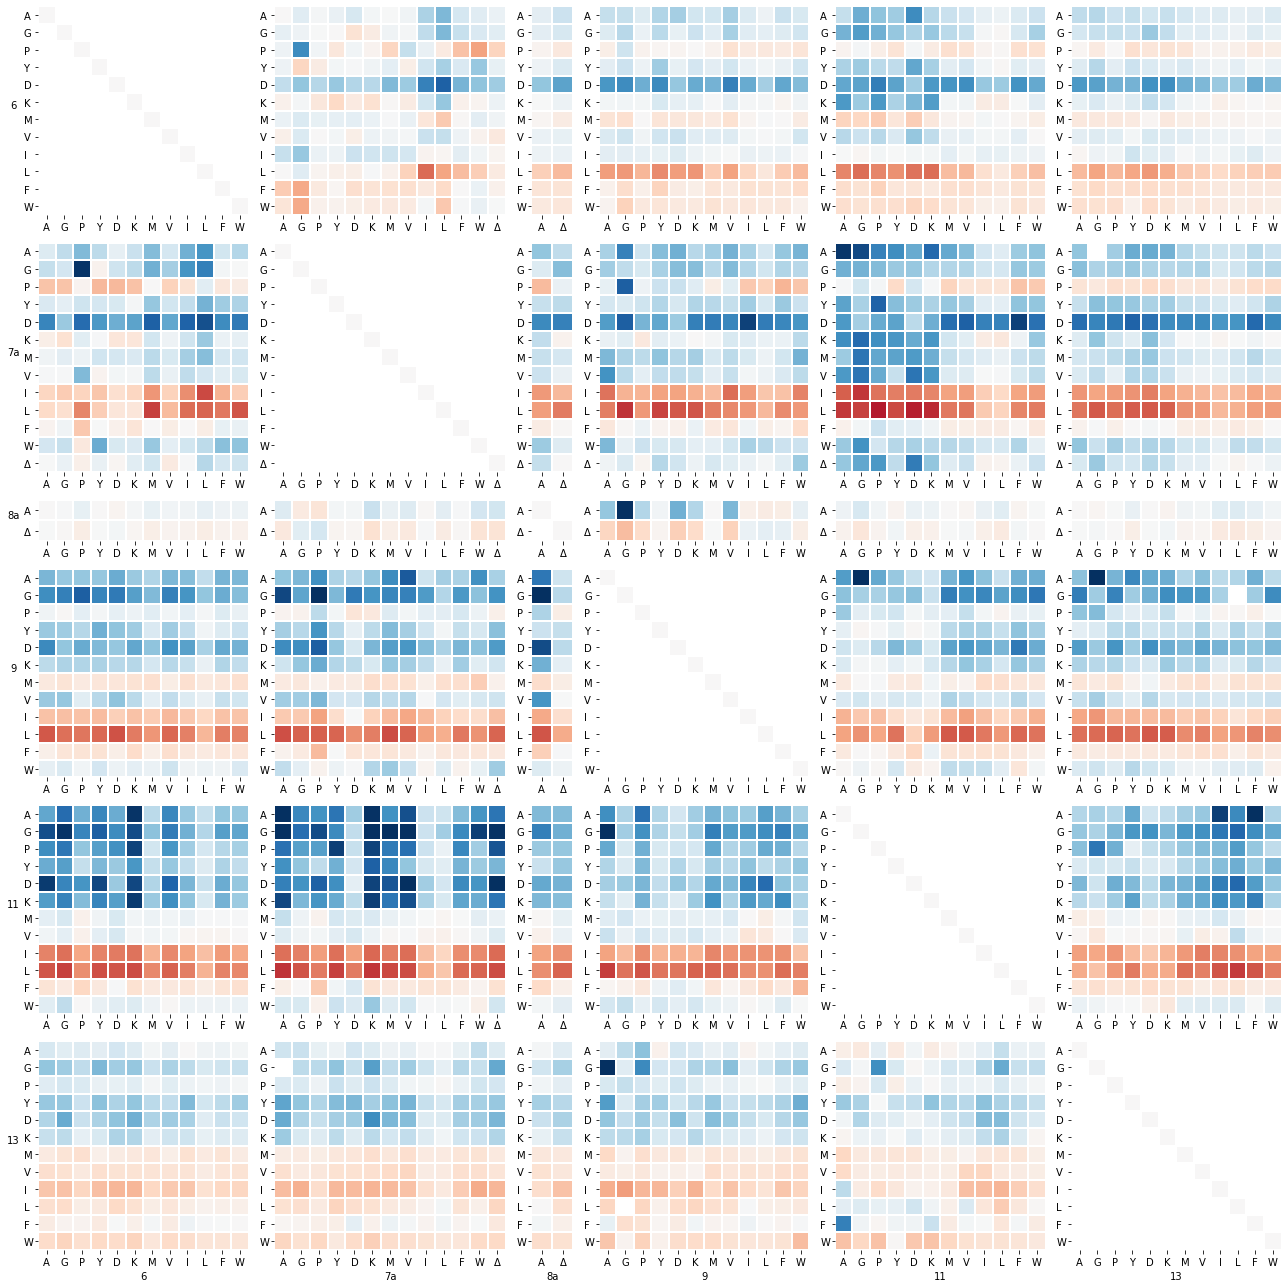

In [25]:
crange=[-3,3]

fig, axes = plt.subplots(6, 6, figsize=(18,18),
                        gridspec_kw={'width_ratios': [2,2.2,0.4,2,2,2],'height_ratios': [2,2.2,0.4,2,2,2]})

# top left axes = axes[0,0]
# top row, middle = axes[0,2]

for a in range(len(valid_pos)): # a = row index, running from 0 to 4
    for b in range(len(valid_pos)): # b = column index, running from 0 to 4
        ax = axes[a][b]
        sns.heatmap(log_col_dfs[valid_pos[a]][valid_pos[b]], vmin=crange[0], vmax=crange[1], linewidths=0.1, ax=ax, 
                    cmap="RdBu_r", cbar=False)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
        ax.tick_params(axis='y', which='major', pad=11)
        # set labels on the outer edges
        if b == 0:
            ax.set_ylabel(valid_pos[a], rotation=0, labelpad=10)
        if a == 5:
            ax.set_xlabel(valid_pos[b])


plt.tight_layout()
#plt.savefig('S14_2D_conditional_heatmap_log2_-3to3.svg')
plt.show()

The conditional dependence of amino acid preference between six randomised positions.

## Epistasis

In [26]:
mi_ideal_dfs = {posA : {posB : "" for posB in valid_pos} for posA in valid_pos}
df_1D = df_enr/df_enr.sum()

for posA in valid_pos:
    for posB in valid_pos:
        dict_data = {}
        for aaA in splimlib[posA]:
            f_a = df_1D[posA][aaA]
            dict_data[aaA] = []
            for aaB in splimlib[posB]:
                f_b =df_1D[posB][aaB]
                try:
                    dict_data[aaA].append(f_a*f_b)
                except ValueError:
                    dict_data[aaA].append(np.nan)
        mi_ideal_dfs[posA][posB] = pd.DataFrame.from_dict(dict_data, orient='index', columns=splimlib[posB])

In [27]:
joint_freq_dfs, log_freq_dfs = get_joint_log_dfs(joint_count_dfs, np.log2)

In [28]:
def bottom_epistasis_plot(joint_freq_dfs, ax_lims, log_function=np.log10, filt=None, fname=None):

    fig, axes = plt.subplots(5, 5, figsize=(14,13),
                             gridspec_kw={'width_ratios': [2,2.2,0.35,2,2],'height_ratios': [2.2,0.35,2,2,2]})

    cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]
    
    for a in range(len(valid_pos)): # a = row index, running from 0 to 4
        posA = valid_pos[a]
        for b in range(len(valid_pos)): # b = column index, running from 0 to 4
            posB = valid_pos[b]
            if (b == 5) or (a == 0):
                continue
            elif b >= a:
                axes[a-1][b].axis('off')
                continue
            ax = axes[a-1][b]
            df = (joint_freq_dfs[posA][posB]/mi_ideal_dfs[posA][posB]).apply(log_function)

            if filt == 'Positive':
                df[df < 0] = np.nan
            elif filt == 'Negative':
                df[df > 0] = np.nan
                
            # draw heatmap in a box to delineate plots
            sns.heatmap(df, linewidths=0.1, ax=ax, vmin=ax_lims[0], vmax=ax_lims[1], center=0,
                        cmap="RdBu_r", cbar_ax=axes[0][2], 
                        cbar_kws={'label': '', 'extend': 'both', 'ticks': cbar_ticks}) # all colorbars are plotted to the same axes

            # set labels on the outer edges
            if b == 0:
                ax.set_ylabel(valid_pos[a], rotation=0, labelpad=10)
            if a == 5:
                ax.set_xlabel(valid_pos[b])
                
    # colorbar formatting
    axes[0][2].axis('on')

    plt.tight_layout()
    #if fname:
        #plt.savefig(fname)

    plt.show()

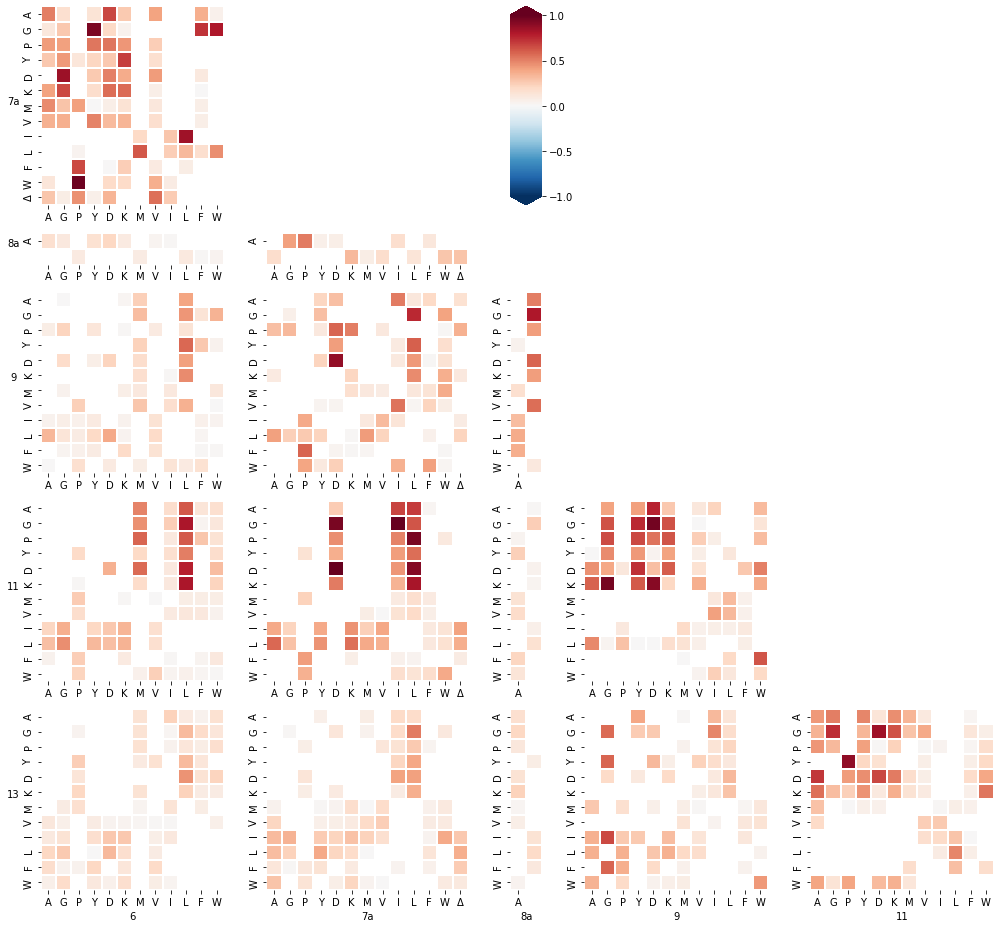

In [29]:
bottom_epistasis_plot(joint_freq_dfs, (-1, 1), log_function=np.log2, filt='Positive', fname='S13_Epistasis_bottom_log2_-1to1_pos.svg')

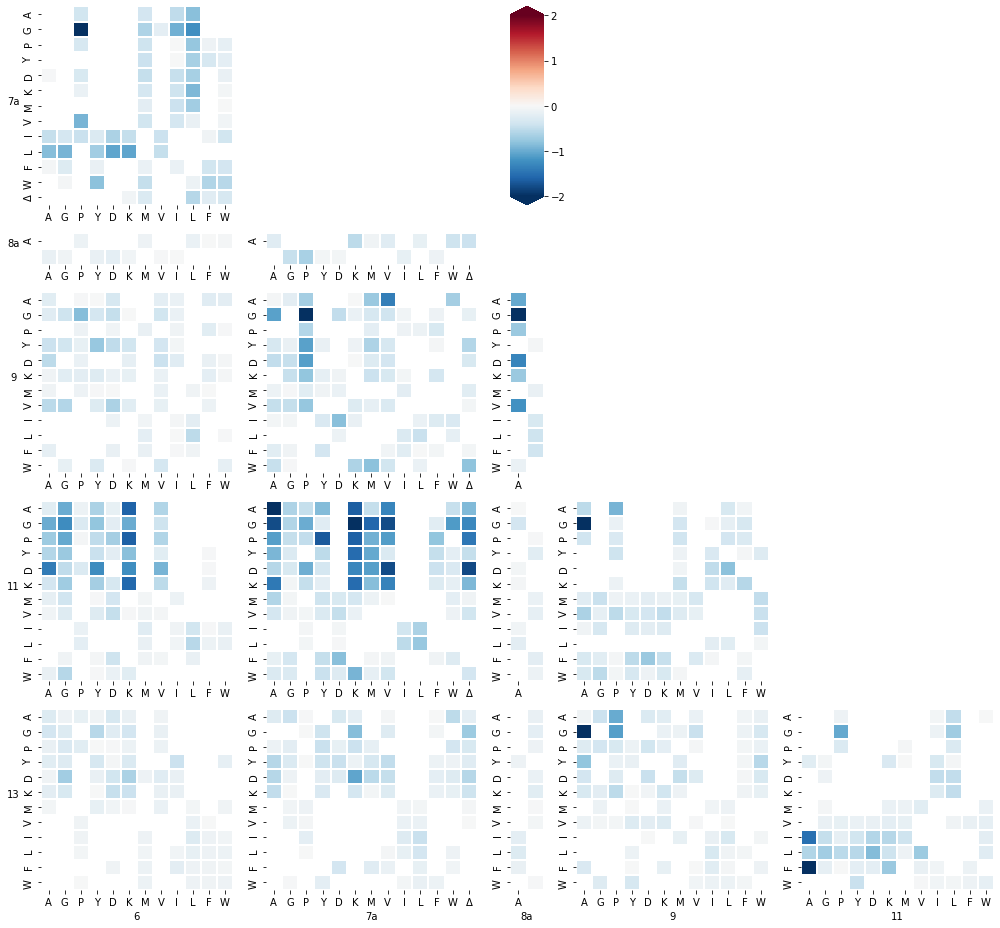

In [30]:
bottom_epistasis_plot(joint_freq_dfs, (-2, 2), log_function=np.log2, filt='Negative', fname='S13_Epistasis_bottom_log2_-2to2_neg.svg')

Suggestive of anchorage effects in I/L in positions 7a, 9 and 11, and MVIW in 13.

## Chi-squared statistics

In [31]:
tot = 29563

In [32]:
expected_df = mi_ideal_dfs['6']['13'].apply(lambda x: x*tot)

In [33]:
observed_df = joint_count_dfs['6']['13']

In [34]:
observed_df.sum().sum()

29563

In [35]:
stats.chisquare(observed_df, expected_df, axis=None)

Power_divergenceResult(statistic=381.5786442252157, pvalue=1.3041010643901695e-23)

In [36]:
pos_order = ['6', '7a', '8a', '9', '11',  '13']
tot = 29563

for i in range(len(pos_order)):
    a = pos_order[i]
    for j in range(i+1, len(pos_order)):
        b = pos_order[j]

        observed_df = joint_count_dfs[a][b]
        expected_df = mi_ideal_dfs[a][b].apply(lambda x: x*tot)
        ch = stats.chisquare(observed_df, expected_df, axis=None)
        print(a, b, ch[1]*15, sep=',')

6,7a,0.0
6,8a,5.421413806742314e-16
6,9,2.4655030629086645e-60
6,11,6.617207454601032e-220
6,13,1.9561515965852541e-22
7a,8a,3.4287923819858656e-224
7a,9,1.981744932874087e-221
7a,11,0.0
7a,13,5.684861808557045e-91
8a,9,0.0
8a,11,1.4992880285776153e-55
8a,13,3.501391869924449e-45
9,11,3.772278249656504e-151
9,13,7.701564754030895e-96
11,13,1.9180925977104613e-181


In [37]:
ch[1]

1.2787283984736408e-182

## Zoom in on beneficial epistasis

Suggestive of anchorage effects in I/L in positions 7a, 9 and 11, and MVIW in 13.

In [38]:
pos_order = ['6', '7a', '8a', '9', '11',  '13']

hydrophobics = {'6': ['P', 'M','L', 'F', 'V'],
                 '7a': ['I', 'L', 'P'],
                  '9': ['I', 'L', 'F', 'M'],
                 '11':['I','L', 'F'],
                 '13': ['M', 'V', 'I', 'F', 'L', 'W']}

i_l = {'6': ['P', 'M','L', 'F', 'V'],
        '7a': ['I', 'L', 'P'],
        '9': ['I', 'L'],
        '11':['I','L'],
        '13': ['I', 'L']}


il_strict = {'6': ['I', 'L'],
        '7a': ['I', 'L'],
        '9': ['I', 'L'],
        '11':['I','L'],
        '13': ['I', 'L']}

In [39]:
hpho_1 = []
for k1 in pos_order:
    try:
        hpho_1.append({k1 : hydrophobics[k1]})
    except KeyError:
        pass

In [40]:
il_1 = []
for k1 in pos_order:
    try:
        il_1.append({k1 : il_strict[k1]})
    except KeyError:
        pass

In [41]:
def find_non_pref_aa(r1):
    r2 = []
    for combo in r1:
        allowed = {}
        for p, good_aa in combo.items():
            bad_aa = [aa for aa in splimlib[p] if not aa in good_aa]
            allowed[p] = bad_aa
        r2.append(allowed)

    return r2

In [42]:
def restricted_preference_plots(ax_lims, log_function, rest, fname='', fsize=(12,6)):
    
    cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]
    
    fig, axes = plt.subplots(2, len(rest) +1,  figsize=fsize,
                            gridspec_kw={'wspace':0.3, 'hspace':0.3})
    rest2 = find_non_pref_aa(rest)
    # add the 1D unrestricted plot
    log_enr = (df_enr/(df_enr.sum()/df_enr.astype(bool).sum())).apply(log_function)   
    sns.heatmap(log_enr, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.1, ax=axes[0][0], cmap="RdBu_r", 
                cbar=False)
    axes[0][0].set_title('All')
    axes[1][0].axis('off')

    for i in range(1,len(rest)+1):
        r = i-1
        
        # top plot: normalise the df relative to even library
        cnts = single_fraction_enrichment(pos, 'high', 1, rest[r], proportion=False)
        df_restrict = pd.DataFrame.from_dict(cnts).reindex(aa_order)
        log_df = (df_restrict/(df_restrict.sum()/df_restrict.astype(bool).sum())).apply(log_function)   
        sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[0][i], cmap="RdBu_r", cbar=False)
        t1 = ', '.join(rest[r].keys())
        t2 = 'n = {}'.format(f"{df_restrict.sum()[1]:,}")
        axes[0][i].set_title('{}\n{}'.format(t1, t2))

        # bottom plot: what happens with the inverse sequence restriction
        cnts = single_fraction_enrichment(pos, 'high', 1, rest2[r], proportion=False)
        df_restrict = pd.DataFrame.from_dict(cnts).reindex(aa_order)
        log_df = (df_restrict/(df_restrict.sum()/df_restrict.astype(bool).sum())).apply(log_function)   
        sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[1][i], cmap="RdBu_r", cbar=False)
        t2 = 'n = {}'.format(f"{df_restrict.sum()[1]:,}")
        axes[1][i].set_title(t2)
    
    for ax in axes.flat:
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()
    #if fname:
       #plt.savefig(fname, dpi=300)
    plt.show()

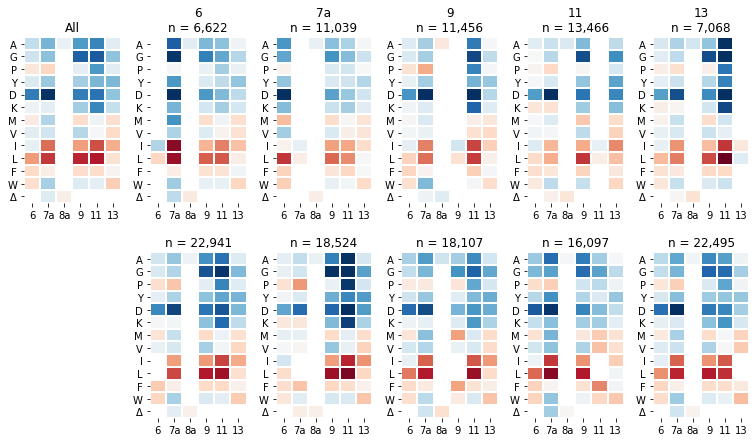

In [43]:
restricted_preference_plots((-2, 2), np.log2, il_1, fname = 'S15_Phi_log2_-2to2.svg', fsize=(13,7))

In [44]:
df_restrict.sum()

6     9550
7a    9550
8a    9550
9     9550
11    9550
13    9550
dtype: int64

#### Relative single motif change in distribution

In [45]:
def restricted_preference_change_plots(ax_lims, log_function, rest, fname='', fsize=(10,6)):

    fig, axes = plt.subplots(2, len(rest),  figsize=fsize)
    rest2 = find_non_pref_aa(rest)
    
    for i in range(len(rest)):
        # top plot: with hydrophobic residues
        cnts = single_fraction_enrichment(pos, 'high', 1, rest[i], proportion=False)
        df_restrict = pd.DataFrame.from_dict(cnts).reindex(aa_order)
        top_df = df_restrict/df_restrict.sum()
        mask = df_restrict.astype(bool)
        b_df = df_enr.where(mask)/ df_enr.where(mask).sum()
        log_df = (top_df/b_df).apply(np.log2)   
        sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[0][i], cmap="RdBu_r",  cbar=False)
        axes[0][i].set_title(', '.join(rest[i].keys()))

        # bottom  plot: normalise the df relative to df_enr (unrestricted)
        
        cnts = single_fraction_enrichment(pos, 'high', 1, rest2[i], proportion=False)
        df_restrict = pd.DataFrame.from_dict(cnts).reindex(aa_order)
        top_df = df_restrict/df_restrict.sum()
        mask = df_restrict.astype(bool)
        b_df = df_enr.where(mask)/ df_enr.where(mask).sum()
        log_df = (top_df/b_df).apply(np.log2)   
        sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[1][i], cmap="RdBu_r",  cbar=False)


    for ax in axes.flat:
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()
   # if fname:
   #     plt.savefig(fname)
    plt.show()

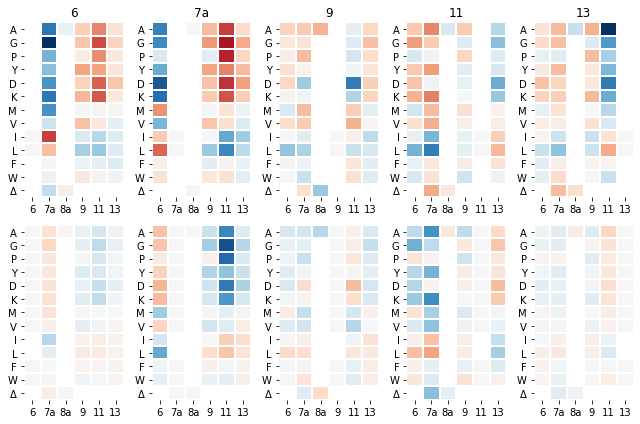

In [46]:
restricted_preference_change_plots((-1, 1), np.log2, il_1, 'S15_Phi_log2_relative_-1to1.svg', (9,6))

Moving a single fixed hydrophobic Leu/Ile residue across the D-domain?
- 6: sets a mild preference for a hydrophobic in 7a and a mild relaxation towards the end of D-domain, but the change is very minor.
- 7a: a fairly strong efect that fixes 6Leu/Met, has little effect on 9 (that is, a strong preference of I/L remains, but 11 greatly relaxes towards non-hydrophobics.
- 9: few changes to overall sequence preference, keeping a preference for hydrophobics in 7a and 11. However, without Leu/Ile at 9, the preferences look mostly unchanged, because other hydrophobic residues can take their place in the middle of the motif.
- 11: 9 keeps the usual preference of Leu/Ile, 13 is shifted towards hydrophobics, while 6 and 7a relax. If there is no Leu/Ile here, then the D-domain hydrophobic sequence shifts towards 6 and 7a.
- 13: some strengthening of preference for 11, 9 remains.

Taken together, this suggests the presence of a core hydrophobic motif in three consecutive randomised positions: 6/7a/9, 7a/9/11 or 9/11/13.

### Consecutive two-residue motifs

In [47]:
aa_pairs = [['6', '7a'], ['7a', '9'], ['9', '11'], ['11', '13']]

il_2 = [{k: il_strict[k] for k in p} for p in aa_pairs]

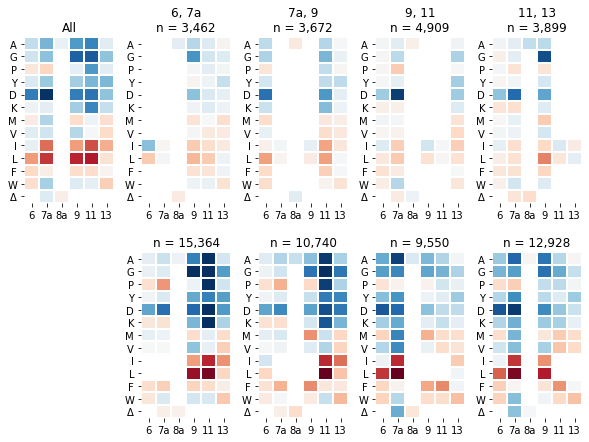

In [48]:
restricted_preference_plots((-2, 2), np.log2, il_2, 'S16_PhiXPhi_log2_-2to2.svg', (10,7))

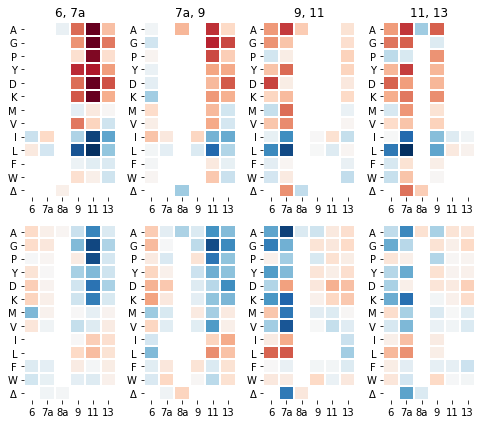

In [49]:
restricted_preference_change_plots((-1, 1), np.log2, il_2,'S16_PhiXPhi_log2_relative_-1to1.svg', (6.8,6))

### Non-consecutive two-residue motifs: ΦXXXΦ

In [50]:
nc_aa_pairs = [['6', '9'], ['7a', '11'], ['9', '13']]

il_3 = [{k: il_strict[k] for k in p} for p in nc_aa_pairs]

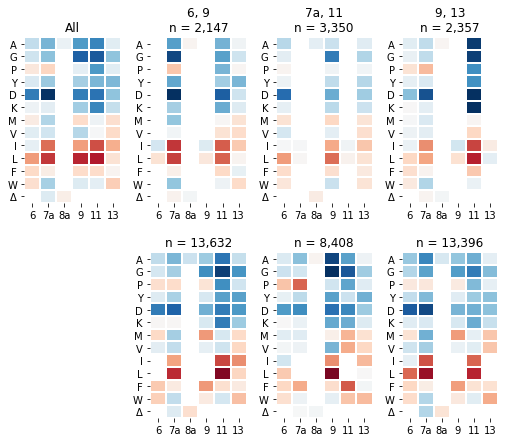

In [51]:
restricted_preference_plots((-2, 2), np.log2, il_3, 'S17_PhiXXXPhi_log2_-2to2.svg', fsize=(8.5,7))

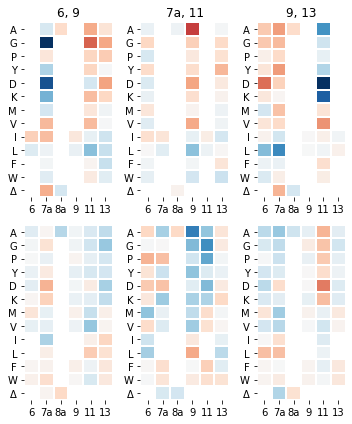

In [52]:
restricted_preference_change_plots((-1, 1), np.log2, il_3,'S17_PhiXXXPhi_log2_relative_-1to1.svg', fsize=(5,6))

## Generate FASTA files for weblogos in different scenarios

In [53]:
il_3 = [ {'7a': ['I', 'L', 'P'], '9': ['I', 'L']},
 {'9': ['I', 'L'], '11': ['I', 'L']}]

In [54]:
zero_rest = [{}]

In [55]:
def generate_weblogo_fasta_from_df(df_pos, rest, names):
    valid_aa = {'A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y', 'Δ'}
    valid_positions = ['6', '7a', '8a', '9', '11', '13']
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}
    
    # make the inverted restrictions
    rest2 = find_non_pref_aa(rest) 
    
    for i in range(len(rest)):
        # different sets of restrictions
        # set up condition name and open the file
        condition_names = ['Hydrophobic_' + names[i] +'.fa', 'Polar_' + names[i]+'.fa']
        
        for c in [0, 1]:
            # 0 = hydrophobic, 1 = inverse
            with open(condition_names[c], 'w') as f:     
                lines = []
                # the variants are the df_pos index
                for v in df_pos.index:
                    m_by_pos = convert_variant_to_dict(v)
                    # check that this variant fits the restriction
                    # the constrains has the form of a dictionary with allowed amino acids in that position
                    if c == 0:
                        if not passes_restriction(m_by_pos, rest[i]):
                            continue
                    else:
                        if not passes_restriction(m_by_pos, rest2[i]):
                            continue  

                    # mask the deletions in the sequence so that weblogo doesn't crash
                    var_list = []
                    for p in valid_positions:
                        aa = m_by_pos[p]
                        if aa == 'Δ':
                            var_list.append('S')
                        else:
                            var_list.append(aa)
                    assert len(var_list) == 6
                    lines.append('>' + str(v) + '\n')
                    lines.append(''.join(var_list) + '\n')
                f.writelines(lines)

In [56]:
generate_weblogo_fasta_from_df(df_pos, il_3, ['7a-9', '9-11'])

In [57]:
generate_weblogo_fasta_from_df(df_pos, zero_rest, ['All'])